In [98]:
import cv2
import numpy as np
import toml
import os
import msgpack as mp
import msgpack_numpy as mpn
import matplotlib.pyplot as plt
from cv2 import aruco
from tqdm import tqdm
import polars as pl
from pd_support import *

from scipy.spatial.transform import Rotation as R

Loading camera calibration

In [99]:
# data = toml.load("../undistort_fisheye_mono_1200_800.toml")
# data = toml.load("../undistort_best.toml")
# data = toml.load("../calib_mono_1200_800.toml")
# data = toml.load("../calib_undistort_aruco.toml")
data = toml.load("../calib_mono_faith.toml")
data = toml.load("../calib_mono_faith2D.toml")
# data = toml.load("../calib_mono_faith3D.toml")
camera_matrix = np.array(data["calibration"]["camera_matrix"]).reshape(3, 3)
dist_coeff = np.array(data["calibration"]["dist_coeffs"])

_parent_dir = os.path.join(os.path.dirname(os.getcwd()), "example_dataset")
# _parent_dir = r"E:\CMC\pyprojects\DeepVision\recorded_data\five_marker_validation"
# _folder_name = "mono2_3d_trial0"
_folder_name = "spot_mono_t0"
_base_pth = os.path.join(_parent_dir, "recordings", _folder_name)

In [100]:
camera_matrix

array([[760.22369678,   0.        , 615.89038767],
       [  0.        , 755.33591731, 362.96868006],
       [  0.        ,   0.        ,   1.        ]])

In [101]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36H11)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

default_ids = [4, 8, 12, 14, 20]

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [102]:
def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs = []
    tvecs = []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            True,
            flags=cv2.SOLVEPNP_IPPE_SQUARE,
        )
        if r is not None and t is not None:
            r = np.array(r).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
            rvecs.append(r)
            tvecs.append(t)
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

In [103]:
# data = toml.load("../undistort_best.toml")
# data = toml.load("../calib_mono_1200_800.toml")
# data = toml.load("../calib_undistort_aruco.toml")
# data = toml.load("../calib_mono_faith3D.toml")
_camera_matrix = np.array(data["calibration"]["camera_matrix"]).reshape(3, 3)
_dist_coeff = np.array(data["calibration"]["dist_coeffs"])

In [104]:
rvecs, tvecs = [], []
with open(os.path.join(_base_pth, "webcam_color.msgpack"), "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    img_size = next(unpacker)
    for _frame in tqdm(unpacker):
        corners, ids = _frame
        # if corners:
        #     _corners = cv2.undistortImagePoints(np.array(corners[0]), camera_matrix, dist_coeff)
        # else:
        #     _corners = None

        if (ids is not None and len(ids) > 0) and all(
            item in default_ids for item in np.array(ids)
        ):
            rotation_vectors, translation_vectors = estimate_pose_single_markers(
                corners=corners,
                marker_size=0.05,
                camera_matrix=_camera_matrix,
                distortion_coefficients=_dist_coeff,
            )
            rvecs.append(rotation_vectors[0][0])
            tvecs.append(translation_vectors[0][0])

        else:
            rvecs.append(np.array([np.nan, np.nan, np.nan]))
            tvecs.append(np.array([np.nan, np.nan, np.nan]))

timestamp = []
sync = []
spot_trigger = []
with open(os.path.join(_base_pth, "webcam_timestamp.msgpack"), "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)

    for _p in unpacker:
        sync.append(_p[1])
        timestamp.append(_p[0])
        spot_trigger.append(_p[2])
        # print(_p)
tvecs = np.array(tvecs)
rvecs = np.array(rvecs)
sync = np.array(sync).astype(bool)

_spot_trigger = []
for _s in spot_trigger:
    # print(_s)
    if _s == "NA":
        _spot_trigger.append(np.nan)
    else:
        _spot_trigger.append(int(_s))

10536it [00:00, 35289.23it/s]


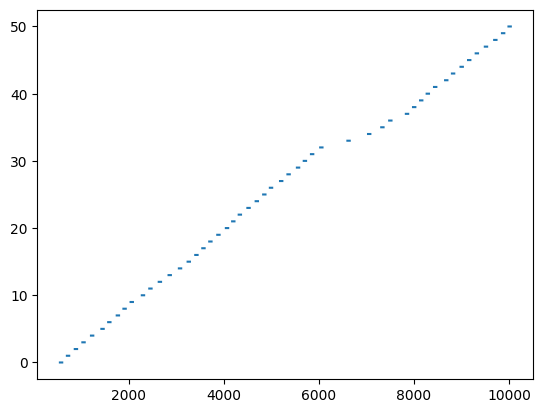

In [105]:
plt.plot(np.array(_spot_trigger))

In [106]:
ar_dict = {
    "time": timestamp,
    "sync": sync,
    "x": tvecs[:, 0],
    "y": tvecs[:, 1],
    "z": tvecs[:, 2],
    "rx": rvecs[:, 0],
    "ry": rvecs[:, 1],
    "rz": rvecs[:, 2],
}
ar_df = pl.from_dict(ar_dict)
if type(ar_df["time"][0]) is not datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())

In [107]:
pulse_sweep = False
for idx, val in enumerate(ar_df["sync"]):
    if val == True and not pulse_sweep:
        start_pulse = idx
        pulse_sweep = True
    if val == False and pulse_sweep:
        end_pulse = idx
        break
ar_df = ar_df[start_pulse:end_pulse]
_spot_trigger = _spot_trigger[start_pulse:end_pulse]

In [108]:
mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, f"{_folder_name}.csv"))
# mocap_df, st_time = read_rigid_body_csv(r"E:\CMC\pyprojects\DeepVision\recorded_data\five_marker_validation\mocap\coord_3d.csv")
mocap_df = add_datetime_col(mocap_df, st_time, "seconds")
mocap_df = pl.from_pandas(mocap_df)

e:\CMC\pyprojects\programs_rpi\rpi_python\notebooks\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [109]:
tr = get_rb_marker_name(1)
tl = get_rb_marker_name(4)
br = get_rb_marker_name(5)
bl = get_rb_marker_name(6)

In [110]:
_time_diff = ar_df["time"][0] - mocap_df["time"][0]

ar_df = ar_df.with_columns([(pl.col("time") - _time_diff).alias("time")])

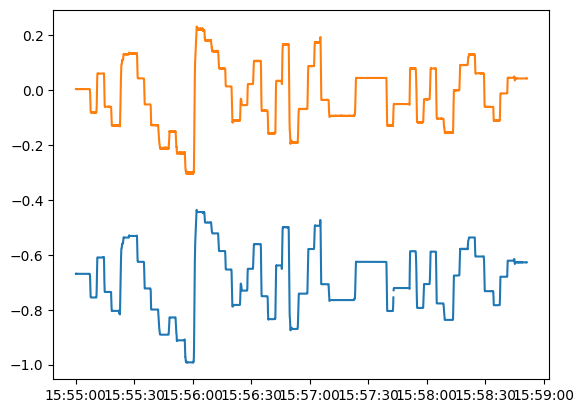

In [111]:
plt.plot(mocap_df["time"], mocap_df[tr["x"]])
plt.plot(ar_df["time"], ar_df["x"])

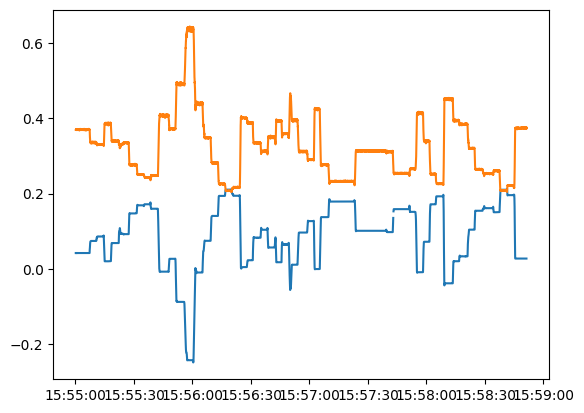

In [112]:
plt.plot(mocap_df["time"], mocap_df[tr["z"]])
plt.plot(ar_df["time"], ar_df["z"])

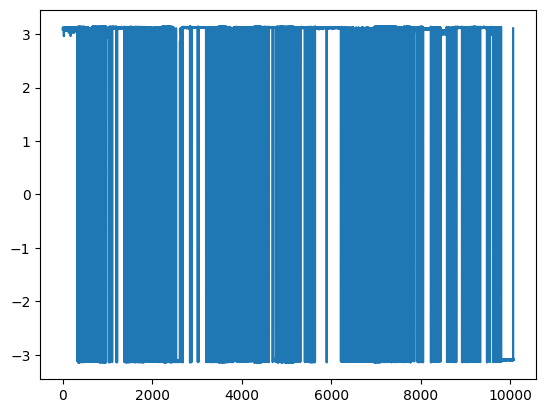

In [113]:
plt.plot(ar_df["rx"])

In [114]:
t_dict = {"x": [], "y": [], "z": []}
rmat = cv2.Rodrigues(ar_df[["rx", "ry", "rz"]][1].to_numpy())[0]

for i in range(len(ar_df["time"])):
    tvec = rmat.T @ (
        ar_df[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
        - ar_df[["x", "y", "z"]][1].to_numpy().reshape(3, 1)
    )
    tvec = tvec.T[0]
    t_dict["x"].append(tvec[0])
    t_dict["y"].append(tvec[1])
    t_dict["z"].append(tvec[2])

In [115]:
tvec

array([ 0.03897007,  0.00059641, -0.00083014], dtype=float32)

In [116]:
mocap_mean = {"x": [], "y": [], "z": []}
mocap_mean["x"] = mocap_df[[tr["x"], tl["x"], br["x"], bl["x"]]].to_numpy().mean(axis=1)
mocap_mean["y"] = mocap_df[[tr["y"], tl["y"], br["y"], bl["y"]]].to_numpy().mean(axis=1)
mocap_mean["z"] = mocap_df[[tr["z"], tl["z"], br["z"], bl["z"]]].to_numpy().mean(axis=1)

mocap_qt = mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]][0].to_numpy()

mocap_rotation = R.from_quat(mocap_qt).as_matrix()

In [117]:
mocap_mean = pl.from_dict(mocap_mean)

In [118]:
mt_dict = {"x": [], "y": [], "z": []}
rmat_m = mocap_rotation[0]

for i in range(len(mocap_df["time"])):
    tvec_ar = rmat_m.T @ (
        mocap_mean[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
        - mocap_mean[["x", "y", "z"]][0].to_numpy().reshape(3, 1)
    )
    tvec_ar = tvec_ar.T[0]
    mt_dict["x"].append(tvec_ar[0])
    mt_dict["y"].append(tvec_ar[1])
    mt_dict["z"].append(tvec_ar[2])

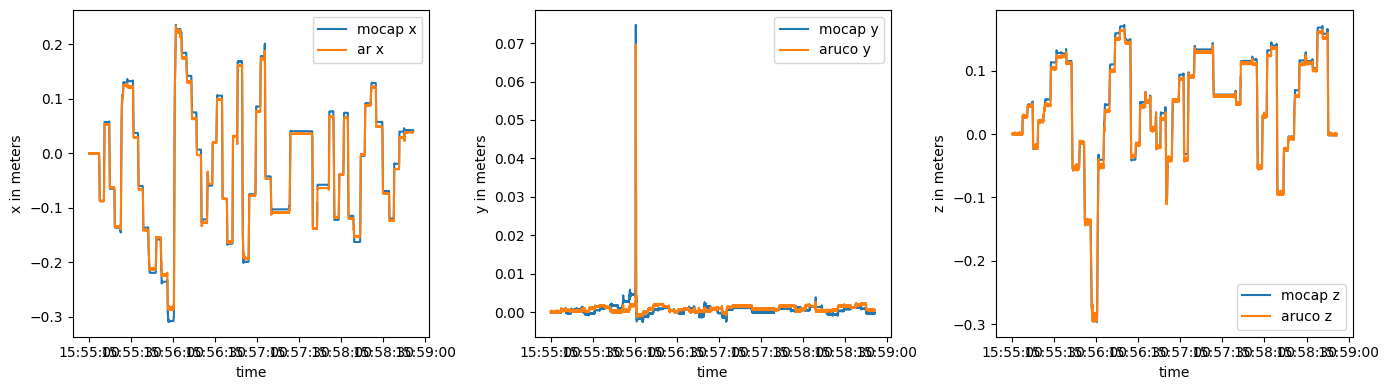

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(mocap_df["time"], mt_dict["x"], label="mocap x")
axes[0].plot(ar_df["time"], t_dict["x"], label="ar x")
axes[0].set_xlabel("time")
axes[0].set_ylabel("x in meters")
axes[0].legend()

axes[1].plot(mocap_df["time"], mt_dict["y"], label="mocap y")
axes[1].plot(ar_df["time"], t_dict["y"], label="aruco y")
axes[1].set_xlabel("time")
axes[1].set_ylabel("y in meters")
axes[1].legend()

axes[2].plot(mocap_df["time"], mt_dict["z"], label="mocap z")
axes[2].plot(ar_df["time"], np.array(t_dict["z"]), label="aruco z")
axes[2].set_xlabel("time")
axes[2].set_ylabel("z in meters")
axes[2].legend()


# axes[2].set_ylim([-0.01, 0.01])

plt.tight_layout()
plt.show()

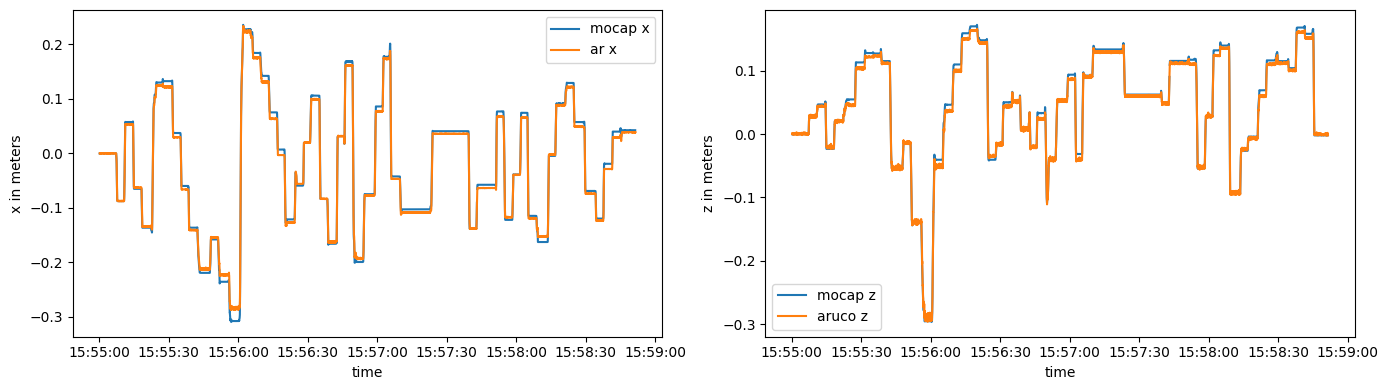

In [120]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(mocap_df["time"], mt_dict["x"], label="mocap x")
axes[0].plot(ar_df["time"], t_dict["x"], label="ar x")
axes[0].set_xlabel("time")
axes[0].set_ylabel("x in meters")
axes[0].legend()

axes[1].plot(mocap_df["time"], mt_dict["z"], label="mocap z")
axes[1].plot(ar_df["time"], np.array(t_dict["z"]), label="aruco z")
axes[1].set_xlabel("time")
axes[1].set_ylabel("z in meters")
axes[1].legend()

plt.tight_layout()
plt.show()

## Interpolation

In [121]:
mt_dict["time"] = mocap_df["time"]

In [122]:
mocap = pl.from_dict(mt_dict)

x1 = interp1d(mocap["time"].dt.epoch(), mocap["x"], fill_value="extrapolate")
y1 = interp1d(mocap["time"].dt.epoch(), mocap["y"], fill_value="extrapolate")
z1 = interp1d(mocap["time"].dt.epoch(), mocap["z"], fill_value="extrapolate")

mocap_ip = {"time": ar_df["time"]}
mocap_ip["x"] = x1(ar_df["time"].dt.epoch())
mocap_ip["y"] = y1(ar_df["time"].dt.epoch())
mocap_ip["z"] = z1(ar_df["time"].dt.epoch())
mocap_ip = pl.from_dict(mocap_ip)

In [123]:
_err_x = np.nanmean(abs(mocap_ip["x"] - np.array(t_dict["x"])))
_err_y = np.nanmean(abs(mocap_ip["y"] - np.array(t_dict["y"])))
_err_z = np.nanmean(abs(mocap_ip["z"] - np.array(t_dict["z"])))

_max_x = np.nanmax(abs(mocap_ip["x"] - np.array(t_dict["x"])))
_max_y = np.nanmax(abs(mocap_ip["y"] - np.array(t_dict["y"])))
_max_z = np.nanmax(abs(mocap_ip["z"] - np.array(t_dict["z"])))

_sd_x = np.nanstd(abs(mocap_ip["x"] - np.array(t_dict["x"])).to_numpy())
_sd_y = np.nanstd(abs(mocap_ip["y"] - np.array(t_dict["y"])).to_numpy())
_sd_z = np.nanstd(abs(mocap_ip["z"] - np.array(t_dict["z"])).to_numpy())

In [124]:
ar_tdf = pl.from_dict(t_dict)

In [125]:
starting_indexes = []
counter = 1
for idx, _s in enumerate(_spot_trigger):
    if _s == counter:
        starting_indexes.append(idx)
        counter += 1

In [126]:
mean_ardict = {"x": [], "y": [], "z": []}
mean_mocapdict = {"x": [], "y": [], "z": []}

error_dict = {"x": [], "y": [], "z": []}
std_dict = {"x": [], "y": [], "z": []}

std_static = {"x": [], "y": [], "z": []}
for _s in starting_indexes:
    mean_ardict["x"].append(np.nanmean(ar_tdf["x"][_s : _s + 50]))
    mean_ardict["y"].append(np.nanmean(ar_tdf["y"][_s : _s + 50]))
    mean_ardict["z"].append(np.nanmean(ar_tdf["z"][_s : _s + 50]))

    mean_mocapdict["x"].append(np.nanmean(mocap_ip["x"][_s : _s + 50]))
    mean_mocapdict["y"].append(np.nanmean(mocap_ip["y"][_s : _s + 50]))
    mean_mocapdict["z"].append(np.nanmean(mocap_ip["z"][_s : _s + 50]))

    std_static["x"].append(np.nanstd(ar_tdf["x"][_s : _s + 50]))
    std_static["y"].append(np.nanstd(ar_tdf["y"][_s : _s + 50]))
    std_static["z"].append(np.nanstd(ar_tdf["z"][_s : _s + 50]))

    error_dict["x"].append(
        np.nanmean(abs(ar_tdf["x"][_s : _s + 50] - mocap_ip["x"][_s : _s + 50]))
    )
    error_dict["y"].append(
        np.nanmean(abs(ar_tdf["y"][_s : _s + 50] - mocap_ip["y"][_s : _s + 50]))
    )
    error_dict["z"].append(
        np.nanmean(abs(ar_tdf["z"][_s : _s + 50] - mocap_ip["z"][_s : _s + 50]))
    )

    std_dict["x"].append(
        np.nanstd(abs(ar_tdf["x"][_s : _s + 50] - mocap_ip["x"][_s : _s + 50]))
    )
    std_dict["y"].append(
        np.nanstd(abs(ar_tdf["y"][_s : _s + 50] - mocap_ip["y"][_s : _s + 50]))
    )
    std_dict["z"].append(
        np.nanstd(abs(ar_tdf["z"][_s : _s + 50] - mocap_ip["z"][_s : _s + 50]))
    )

In [144]:
print(np.max(error_dict["x"]), np.max(error_dict["y"]), np.max(error_dict["z"]))
print(np.max(std_dict["x"]), np.max(std_dict["y"]), np.max(std_dict["z"]))
print(
    np.max(std_static["x"]) * 1000,
    np.max(std_static["y"]) * 1000,
    np.max(std_static["z"]) * 1000,
)

0.02333540936489631 0.0028805636410213433 0.009882729852753897
0.0011523812481693517 0.00016626117660678143 0.002902642447203819
1.1507592862471938 0.16648683231323957 2.979538170620799


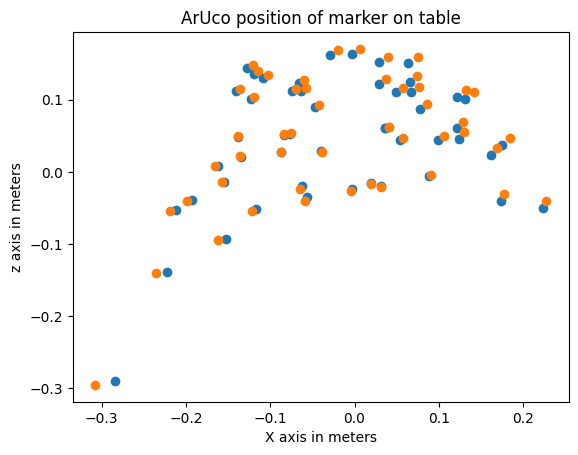

0.004102906778657317 0.0006169410941191997 0.0031477458787560835


In [143]:
plt.plot(mean_ardict["x"], mean_ardict["z"], "o")
plt.plot(mean_mocapdict["x"], mean_mocapdict["z"], "o")
plt.xlabel("X axis in meters")
plt.ylabel("z axis in meters")
plt.title("ArUco position of marker on table")
plt.show()
print(_sd_x, _sd_y, _sd_z)

In [129]:
print(_sd_x, _sd_y, _sd_z)

0.004102906778657317 0.0006169410941191997 0.0031477458787560835


In [130]:
print(_err_x, _err_y, _err_z)

0.005799590694109567 0.0007980109193181224 0.004212458767365438


In [131]:
print(_max_x, _max_y, _max_z)

0.028114968813338415 0.01192962872296751 0.017286525396724803


Angle

In [132]:
rvecs = ar_df[["rx", "ry", "rz"]].to_numpy()
rmats = R.from_rotvec(rvecs).as_matrix()
rotation = np.array([_r.T @ rmats[0] for _r in rmats])
euler_ar = R.from_matrix(rotation).as_euler("ZYX", degrees=True)

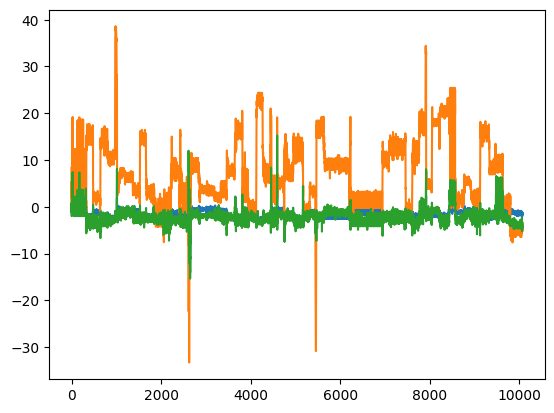

In [133]:
plt.plot(euler_ar)

In [134]:
mocap_qts = mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]].to_numpy()

mocap_rmats = []
for _q in mocap_qts:
    try:
        mocap_rmats.append(R.from_quat(_q).as_matrix())
    except:
        mocap_rmats.append(np.eye(3))
# mocap_rmats = R.from_quat(mocap_qts).as_matrix()

In [135]:
mocap_ang = [_r.T @ mocap_rmats[0] for _r in mocap_rmats]
mocap_euler = R.from_matrix(mocap_ang).as_euler("zyx", degrees=True)

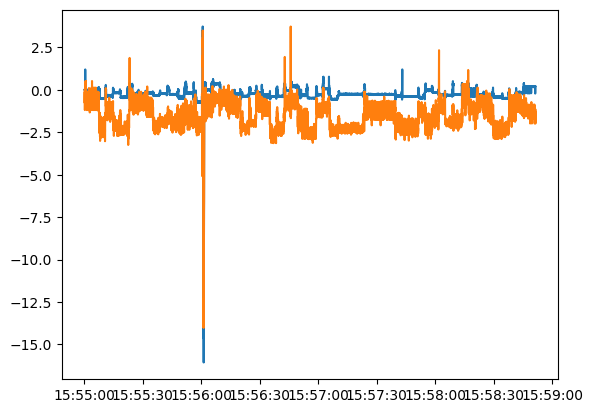

In [136]:
plt.plot(mocap_df["time"], mocap_euler[:, 0])
plt.plot(ar_df["time"], euler_ar[:, 0])

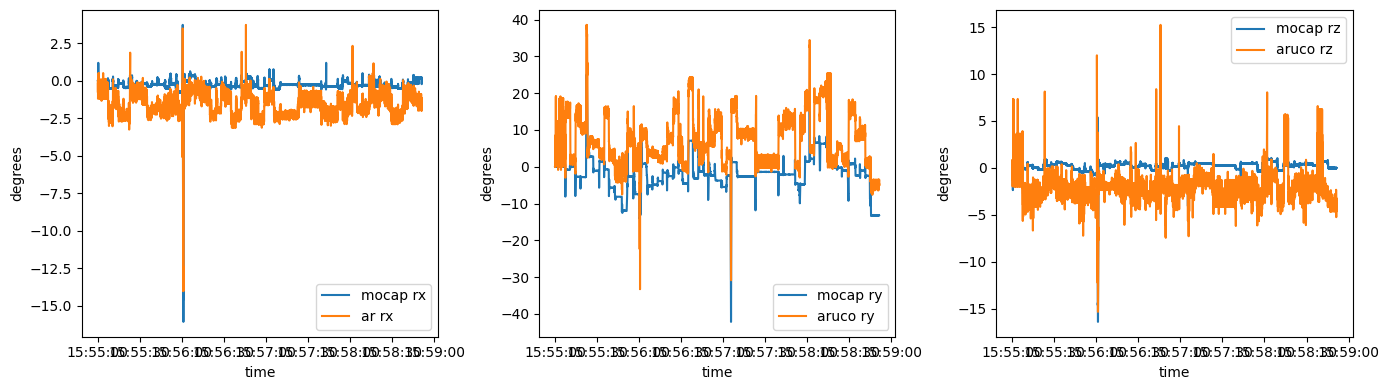

In [137]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(mocap_df["time"], mocap_euler[:, 0], label="mocap rx")
axes[0].plot(ar_df["time"], euler_ar[:, 0], label="ar rx")
axes[0].set_xlabel("time")
axes[0].set_ylabel("degrees")
axes[0].legend()

axes[1].plot(mocap_df["time"], mocap_euler[:, 1], label="mocap ry")
axes[1].plot(ar_df["time"], euler_ar[:, 1], label="aruco ry")
axes[1].set_xlabel("time")
axes[1].set_ylabel("degrees")
axes[1].legend()

axes[2].plot(mocap_df["time"], mocap_euler[:, 2], label="mocap rz")
axes[2].plot(ar_df["time"], euler_ar[:, 2], label="aruco rz")
axes[2].set_xlabel("time")
axes[2].set_ylabel("degrees")
axes[2].legend()


# axes[2].set_ylim([-0.01, 0.01])

plt.tight_layout()
plt.show()

In [138]:
rx1 = interp1d(mocap["time"].dt.epoch(), mocap_euler[:, 0], fill_value="extrapolate")
ry1 = interp1d(mocap["time"].dt.epoch(), mocap_euler[:, 1], fill_value="extrapolate")
rz1 = interp1d(mocap["time"].dt.epoch(), mocap_euler[:, 2], fill_value="extrapolate")

mocap_rip = {"time": ar_df["time"]}
mocap_rip["x"] = rx1(ar_df["time"].dt.epoch())
mocap_rip["y"] = ry1(ar_df["time"].dt.epoch())
mocap_rip["z"] = rz1(ar_df["time"].dt.epoch())
mocap_rip = pl.from_dict(mocap_rip)

In [139]:
_err_rx = np.nanmean(abs(mocap_rip["x"] - euler_ar[:, 0]))
_err_ry = np.nanmean(abs(mocap_rip["y"] - euler_ar[:, 1]))
_err_rz = np.nanmean(abs(mocap_rip["z"] - euler_ar[:, 2]))

_max_rx = np.nanmax(abs(mocap_rip["x"] - euler_ar[:, 0]))
_max_ry = np.nanmax(abs(mocap_rip["y"] - euler_ar[:, 1]))
_max_rz = np.nanmax(abs(mocap_rip["z"] - euler_ar[:, 2]))

_sd_rx = np.nanstd(abs(mocap_rip["x"] - euler_ar[:, 0]))
_sd_ry = np.nanstd(abs(mocap_rip["y"] - euler_ar[:, 1]))
_sd_rz = np.nanstd(abs(mocap_rip["z"] - euler_ar[:, 2]))

In [140]:
print(_sd_rx, _sd_ry, _sd_rz)

0.6164356479247305 4.869712990439774 0.9793910468123407


In [141]:
print(_err_rx, _err_ry, _err_rz)

1.3204549075056782 9.22124950713499 2.5569171410633125


In [142]:
print(_max_rx, _max_ry, _max_rz)

4.594360702833372 26.5237727894131 14.941672359846573
